
# <span style="font-variant: small-caps"> Introduction into Big Data analytics </span>

## Assignment 2
Wiktoria Stępień
Dominika Struzik

### Task 1

Given a 2D matrix (or list of lists), count how many numbers are present in a given range.

In [1]:
import numpy as np
from functools import reduce

In [24]:
def count_in_range(matrix, lower, upper): # it counts numbers between [lower, upper] interval   
    return ((matrix >= lower) & (matrix <= upper)).sum()

In [25]:
def reducer(x, y):
    return x + y

def count_in_range_mapreduce(matrix, lower, upper):
    mapper = lambda value: int((value >= lower) & (value <= upper))
    mapped = map(mapper, matrix.flatten())         # we use flatten() to change matrix into one dimension, works very fast, it does not really affect the execution time
    reduced = reduce(reducer, mapped)
    return reduced

In [26]:
mx = np.random.randint(0,99,(1000,1000))
mx

array([[68, 17, 25, ..., 93, 28, 64],
       [84, 88, 73, ..., 39, 29, 26],
       [49, 21, 24, ..., 77, 45, 62],
       ...,
       [17,  5, 16, ..., 93, 78, 79],
       [65, 65, 80, ..., 80, 29, 12],
       [40, 20, 32, ..., 88, 62, 82]])

In [27]:
%%time
count_in_range(mx, 1, 9)

Wall time: 32 ms


91241

In [28]:
%%time
count_in_range_mapreduce(mx, 1, 9)

Wall time: 1.78 s


91241

In [29]:
from multiprocessing import Pool
from multiprocessing import cpu_count

In [30]:
# in order to use functions belowe with multiprocessing in Windows, we used the advised approach
# and we have created a file a2_func.py with all the functions needed in this list,
# then we import them here (the need especially for chunks mapper)

In [31]:
lower = 1
upper = 9

def mapper(x):
    return int((x[0] >= x[1]) & (x[0] <= x[2]))

def reducer(x, y):
    return x + y

def chunks_mapper(chunk):
    mapped_chunk = map(mapper, chunk) 
    return reduce(reducer, mapped_chunk)

In [32]:
import a2_func
import imp
imp.reload(a2_func)

<module 'a2_func' from 'C:\\Programy\\python\\Python 3.8\\ItBDA\\LIST 2\\a2_func.py'>

In [33]:
def count_in_range_mapreduce_multipr(matrix, lower, upper):
    if __name__ ==  '__main__': 
        pool = Pool(cpu_count()) #cpu_count() = 4
        all_cells = matrix.flatten()
        zipped = zip(all_cells, [lower]*len(all_cells), [upper]*len(all_cells))
        data_chunks = np.array_split(list(zipped), 10)
        mapped = pool.map(a2_func.chunks_mapper, data_chunks)
        reduced = reduce(reducer, mapped)
        return reduced

In [34]:
%%time
# time with using multiprocessing

count_in_range_mapreduce_multipr(mx, 1, 9)

Wall time: 5.87 s


91241

In [35]:
%%time
# time without using multiprocessing

lower = 1
upper = 9
all_cells = mx.flatten()
zipped = zip(all_cells, [lower]*len(all_cells), [upper]*len(all_cells))
reduce(reducer, map(chunks_mapper, np.array_split(list(zipped),2)))

Wall time: 3.22 s


91241

### Task 2

Download as many books as possible from the Gutenberg project and:
 * count the words in all books,
 * compute a histogram of the words

In [4]:
import glob

In [16]:
import requests

for i in range(500):
    url = 'https://www.gutenberg.org/cache/epub/{}/pg{}.txt'.format(i,i)
    fileName = 'pg{}.txt'.format(i)
    req = requests.get(url)
    file = open(fileName, 'wb')
    for chunk in req.iter_content(100000):
        file.write(chunk)
    file.close()

In [5]:
from nltk.tokenize import word_tokenize 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import Counter

def one_book_word_count(filename):
    with open(filename, "r", encoding="ASCII") as file:
        text = file.read()
    start_idx = text.find('***') + text[text.find('***') + 3 :].find('***') + 6
    end_idx = text.find('*** END')
    text = text[start_idx:end_idx].replace('\n',' ').replace('.',' ').replace(',',' ').replace(':',' ').replace(';',' ').replace('?',
            ' ').replace('!',' ').replace('"',' ').replace("—"," ").replace('_',' ').replace('[',' ').replace(']',' ').replace('(',
            ' ').replace(')',' ').replace('0',' ').replace('1',' ').replace('2',' ').replace('3',' ').replace('4',' ').replace('5',
            ' ').replace('6',' ').replace('7',' ').replace('8',' ').replace('9',' ').lower()
    text_tokenized = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    stop_words = stopwords.words('english')
    text_stem = [lemmatizer.lemmatize(item) for item in text_tokenized if ((len(lemmatizer.lemmatize(item)) > 1) & (item not in stop_words))]
    dict_of_words = dict(Counter(text_stem))
    
    return dict_of_words

In [6]:
def add_word_dicts(dict1, dict2):
    for k, v in dict2.items():
        if k in dict1.keys():
            dict1[k] = dict1[k] + v
        else:
            dict1[k] = v
    return dict1

In [7]:
%%time

if __name__ ==  '__main__': 
    filenames = glob.glob('*.txt')
    pool = Pool(1)
    mapped = pool.map(a2_func.one_book_word_count, filenames[:300])
    reduced = reduce(a2_func.add_word_dicts, mapped)

Wall time: 7min 36s


In [8]:
%%time

if __name__ ==  '__main__':
    filenames = glob.glob('*.txt')
    pool = Pool(None)
    mapped = pool.map(a2_func.one_book_word_count, filenames[:300])
    reduced = reduce(a2_func.add_word_dicts, mapped)

Wall time: 3min 41s


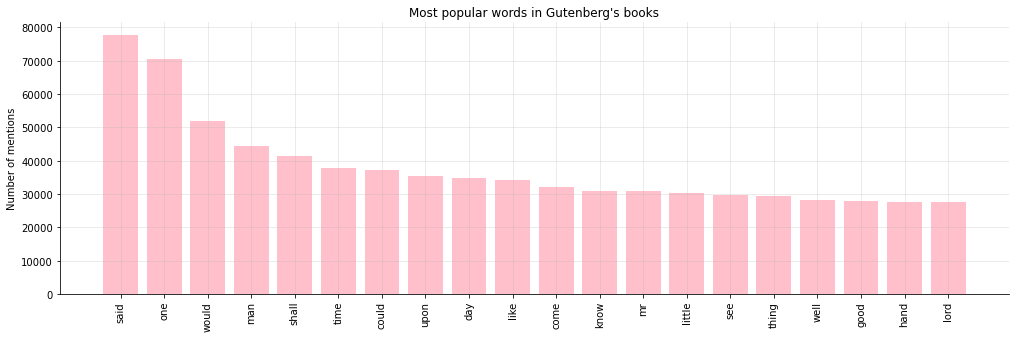

In [9]:
import matplotlib.pyplot as plt

list_of_words = sorted([[word, number] for word, number in reduced.items()], key = lambda x: x[1], reverse=True)
limit = 20
words = [x[0] for x in list_of_words[:limit]]
numbers = [x[1] for x in list_of_words[:limit]]

fig, ax = plt.subplots(1,1, figsize=(17,5))
ax.bar(range(limit), numbers, align='center', color='pink')
ax.set_title("Most popular words in Gutenberg's books")
ax.set_xticks(range(limit))
ax.set_xticklabels(words, rotation='vertical')
ax.set_ylabel('Number of mentions')
ax.spines['top'].set_color(None)
ax.spines['right'].set_color(None)
ax.grid(alpha=0.3)
plt.show()

###  Task 3

Compute exact digits of π using the Bailey-Borwein-Plouffe algorithm.

In [10]:
print(a2_func.nth_pi_digit(0))
print(a2_func.nth_pi_digit(999))

3
d


In [14]:
%%time

if __name__ == '__main__':
    n = 10000
    pool = Pool(1)
    mapped = pool.map(a2_func.nth_pi_digit, range(n))
    reduced = reduce(a2_func.make_pi, mapped)
    reduced = reduced[0] + '.' + reduced[1:]
    print(reduced[:10], ' ... ', reduced[-10:])

3.243f6a88  ...  926aab49ec
Wall time: 10min 22s


In [15]:
%%time

if __name__ == '__main__':
    n = 10000
    pool = Pool(None)
    mapped = pool.map(a2_func.nth_pi_digit, range(n))
    reduced = reduce(a2_func.make_pi, mapped)
    reduced = reduced[0] + '.' + reduced[1:]
    print(reduced[:10], ' ... ', reduced[-10:])

3.243f6a88  ...  926aab49ec
Wall time: 6min 10s


In [16]:
%%time

if __name__ == '__main__':
    n = 100
    pool = Pool(None)
    mapped = pool.map(a2_func.nth_pi_digit, range(n))
    reduced = reduce(a2_func.make_pi, mapped)
    reduced = reduced[0] + '.' + reduced[1:]
    print(reduced)

3.243f6a8885a308d313198a2e03707344a4093822299f31d0082efa98ec4e6c89452821e638d01377be5466cf34e90c6cc0a
Wall time: 3.39 s


### Task 4

Calculate the product of two random matrices

In [15]:
A = np.random.randint(0,9,(200,220))

In [16]:
B = np.random.randint(0,9,(220,150))

In [20]:
%%time

if __name__ ==  '__main__':
    from itertools import chain
    pool = Pool(1)
    
    # A is i x j matrix, but I will put j's as a first argument
    m_A = zip([*range(A.shape[1])] * A.shape[0], chain(*zip(*[range(A.shape[0])] * A.shape[1])), A.flatten(), ['A']*A.shape[0]*A.shape[1])
    # B is j x k, so the first argument fits the same function as for A
    m_B = zip(chain(*zip(*[range(B.shape[0])] * B.shape[1])), [*range(B.shape[1])] * B.shape[0], B.flatten(), ['B']*B.shape[0]*B.shape[1])

    matrices = chain(*zip(m_A), *zip(m_B))
    
    mapped = pool.map(a2_func.make_pairs, matrices)

    all_js = dict()
    for one_cell in mapped:
        j, rest = one_cell
        if j in all_js.keys():
            all_js[j].append(rest)
        else:
            all_js[j] = [rest]
    
    result = reduce(a2_func.sum_up, list(pool.map(a2_func.first_multiply, list(all_js.values()))))

Wall time: 1min 15s


In [21]:
result

[[(0, 0), 3499],
 [(0, 1), 3488],
 [(0, 2), 3589],
 [(0, 3), 3682],
 [(0, 4), 3677],
 [(0, 5), 3446],
 [(0, 6), 3531],
 [(0, 7), 3753],
 [(0, 8), 3532],
 [(0, 9), 3431],
 [(0, 10), 3669],
 [(0, 11), 3741],
 [(0, 12), 3448],
 [(0, 13), 3451],
 [(0, 14), 3519],
 [(0, 15), 3554],
 [(0, 16), 3583],
 [(0, 17), 3634],
 [(0, 18), 3526],
 [(0, 19), 3688],
 [(0, 20), 3473],
 [(0, 21), 3529],
 [(0, 22), 3502],
 [(0, 23), 3850],
 [(0, 24), 3760],
 [(0, 25), 3488],
 [(0, 26), 3391],
 [(0, 27), 3445],
 [(0, 28), 3396],
 [(0, 29), 3461],
 [(0, 30), 3683],
 [(0, 31), 3660],
 [(0, 32), 3560],
 [(0, 33), 3928],
 [(0, 34), 3287],
 [(0, 35), 3303],
 [(0, 36), 3459],
 [(0, 37), 3880],
 [(0, 38), 3165],
 [(0, 39), 3315],
 [(0, 40), 3465],
 [(0, 41), 3516],
 [(0, 42), 3706],
 [(0, 43), 3247],
 [(0, 44), 3521],
 [(0, 45), 3642],
 [(0, 46), 3635],
 [(0, 47), 3639],
 [(0, 48), 3625],
 [(0, 49), 3651],
 [(0, 50), 3619],
 [(0, 51), 3429],
 [(0, 52), 3629],
 [(0, 53), 3571],
 [(0, 54), 3525],
 [(0, 55), 3378],
 [

In [22]:
%%time

if __name__ ==  '__main__':
    from itertools import chain
    pool = Pool(None)
    
    # A is i x j matrix, but I will put j's as a first argument
    m_A = zip([*range(A.shape[1])] * A.shape[0], chain(*zip(*[range(A.shape[0])] * A.shape[1])), A.flatten(), ['A']*A.shape[0]*A.shape[1])
    # B is j x k, so the first argument fits the same function as for A
    m_B = zip(chain(*zip(*[range(B.shape[0])] * B.shape[1])), [*range(B.shape[1])] * B.shape[0], B.flatten(), ['B']*B.shape[0]*B.shape[1])

    matrices = chain(*zip(m_A), *zip(m_B))
    
    mapped = pool.map(a2_func.make_pairs, matrices)

    all_js = dict()
    for one_cell in mapped:
        j, rest = one_cell
        if j in all_js.keys():
            all_js[j].append(rest)
        else:
            all_js[j] = [rest]
    
    result = reduce(a2_func.sum_up, list(pool.map(a2_func.first_multiply, list(all_js.values()))))

Wall time: 55.8 s


In [23]:
result

[[(0, 0), 3499],
 [(0, 1), 3488],
 [(0, 2), 3589],
 [(0, 3), 3682],
 [(0, 4), 3677],
 [(0, 5), 3446],
 [(0, 6), 3531],
 [(0, 7), 3753],
 [(0, 8), 3532],
 [(0, 9), 3431],
 [(0, 10), 3669],
 [(0, 11), 3741],
 [(0, 12), 3448],
 [(0, 13), 3451],
 [(0, 14), 3519],
 [(0, 15), 3554],
 [(0, 16), 3583],
 [(0, 17), 3634],
 [(0, 18), 3526],
 [(0, 19), 3688],
 [(0, 20), 3473],
 [(0, 21), 3529],
 [(0, 22), 3502],
 [(0, 23), 3850],
 [(0, 24), 3760],
 [(0, 25), 3488],
 [(0, 26), 3391],
 [(0, 27), 3445],
 [(0, 28), 3396],
 [(0, 29), 3461],
 [(0, 30), 3683],
 [(0, 31), 3660],
 [(0, 32), 3560],
 [(0, 33), 3928],
 [(0, 34), 3287],
 [(0, 35), 3303],
 [(0, 36), 3459],
 [(0, 37), 3880],
 [(0, 38), 3165],
 [(0, 39), 3315],
 [(0, 40), 3465],
 [(0, 41), 3516],
 [(0, 42), 3706],
 [(0, 43), 3247],
 [(0, 44), 3521],
 [(0, 45), 3642],
 [(0, 46), 3635],
 [(0, 47), 3639],
 [(0, 48), 3625],
 [(0, 49), 3651],
 [(0, 50), 3619],
 [(0, 51), 3429],
 [(0, 52), 3629],
 [(0, 53), 3571],
 [(0, 54), 3525],
 [(0, 55), 3378],
 [

In [19]:
%%time
np.dot(A, B)

Wall time: 9.97 ms


array([[3499, 3488, 3589, ..., 3641, 3588, 3354],
       [3139, 3488, 3191, ..., 3507, 3351, 3222],
       [3152, 3436, 3217, ..., 3249, 3404, 3108],
       ...,
       [3200, 3230, 3160, ..., 3294, 3221, 3034],
       [3295, 3638, 3238, ..., 3582, 3724, 3360],
       [3380, 3684, 3321, ..., 3617, 3727, 3331]])